# Computer Vision - Image Classification example

###### Links: [Dog Breed (Kaggle)](https://www.kaggle.com/competitions/dog-breed-identification/overview)  |  [Article ()]()

### 0 - Setup

###### Import pckgs

In [1]:
import warnings
warnings.filterwarnings("ignore")

## for data
import os
import cv2
import pandas as pd
import numpy as np
from tqdm.notebook  import tqdm

## for plotting
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

## for metrics
from sklearn import metrics

## for cnn
from tensorflow.keras import models, layers, utils, callbacks #(2.6.0)

## for explainer
from lime import lime_image
from skimage import segmentation

## for vit
import transformers

###### Import data

In [2]:
labels = ["scottish_deerhound", "maltese_dog", "afghan_hound", "entlebucher", "bernese_mountain_dog"]

dtf = pd.read_csv("dogs_labels.csv").rename(columns={"breed":"label"})
dtf = dtf[dtf["label"].isin(labels)].sort_values("id").reset_index(drop=True)

dtf["y"] = dtf["label"].factorize(sort=True)[0]
dic_y_mapping = dict( dtf[['y','label']].drop_duplicates().sort_values('y').values )
print(dic_y_mapping)
dtf

{0: 'afghan_hound', 1: 'bernese_mountain_dog', 2: 'entlebucher', 3: 'maltese_dog', 4: 'scottish_deerhound'}


id                 label  y
0    0042188c895a2f14ef64a918ed9c7b64    scottish_deerhound  4
1    00693b8bc2470375cc744a6391d397ec           maltese_dog  3
2    01e787576c003930f96c966f9c3e1d44    scottish_deerhound  4
3    01ee3c7ff9bcaba9874183135877670e           entlebucher  2
4    021b5a49189665c0442c19b5b33e8cf1           entlebucher  2
..                                ...                   ... ..
583  fe3e760d763e186541e18f303cd7caca  bernese_mountain_dog  1
584  fe50bac6c389d137ea01c9cfc7346ca8    scottish_deerhound  4
585  fef5d4cdaf50cf159102e803c7d6aa9c  bernese_mountain_dog  1
586  ff7d9c08091acc3b18b869951feeb013           maltese_dog  3
587  ffa0055ec324829882186bae29491645           maltese_dog  3

[588 rows x 3 columns]

In [3]:
#dirpath = "data_dogs"
#for file in tqdm(os.listdir(dirpath)):
#    filename = os.path.splitext(file)[0]
#    if filename not in dtf["id"].values:
#        os.remove(os.path.join(dirpath, file))

In [4]:
'''
Load a single image with opencv
'''
def load_img(file, ext=['.png','.jpg','.jpeg','.JPG']):
    if file.endswith(tuple(ext)):
        img = cv2.imread(file, cv2.IMREAD_UNCHANGED)
        if len(img.shape) > 2:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        return img
    else:
        print("file extension unknown")

In [5]:
'''
Plot n images in (1 row) x (n columns).
'''
def plot_imgs(imgs, titles=[]):
    ## single image
    if (len(imgs) == 1) or (type(imgs) not in [list,pd.core.series.Series]):
        img = imgs if type(imgs) is not list else imgs[0]
        title = None if len(titles) == 0 else (titles[0] if type(titles) is list else titles)
        fig, ax = plt.subplots(figsize=(5,3))
        fig.suptitle(title, fontsize=15)
        if len(img.shape) > 2:
            plt.imshow(img)
        else:
            plt.imshow(img, cmap=plt.cm.binary)
    
    ## multiple images
    else:
        fig, ax = plt.subplots(nrows=1, ncols=len(imgs), sharex=False, sharey=False, figsize=(4*len(imgs),10))
        if len(titles) == 1:
            fig.suptitle(titles[0], fontsize=15)
        for i,img in enumerate(imgs):
            ax[i].imshow(img)
            if len(titles) > 1:
                ax[i].set(title=titles[i])
    plt.show()

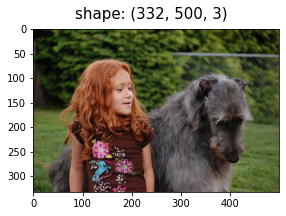

In [6]:
# try one
img = load_img(file="data_dogs/0042188c895a2f14ef64a918ed9c7b64.jpg")
plot_imgs(img, "shape: "+str(img.shape))

In [7]:
# load all
dirpath = "data_dogs"
ext=['.png','.jpg','.jpeg','.JPG']

lst_imgs = []
errors = 0
for file in tqdm(sorted(os.listdir(dirpath))):
    try:
        if file.endswith(tuple(ext)):
            img = load_img(file=os.path.join(dirpath, file), ext=ext)
            lst_imgs.append(img)
    except Exception as e:
        print("failed on:", file, "| error:", e)
        errors += 1
        lst_imgs.append(np.nan)
        pass

dtf["img"] = lst_imgs
dtf = dtf[["id","img","label","y"]]
print("check:", len(lst_imgs), "=", len(dtf), " |  Nas:", errors, "=", dtf["img"].isna().sum())
dtf.head()

  0%|          | 0/588 [00:00<?, ?it/s]

check: 588 = 588  |  Nas: 0 = 0


id  \
0  0042188c895a2f14ef64a918ed9c7b64   
1  00693b8bc2470375cc744a6391d397ec   
2  01e787576c003930f96c966f9c3e1d44   
3  01ee3c7ff9bcaba9874183135877670e   
4  021b5a49189665c0442c19b5b33e8cf1   

                                                 img               label  y  
0  [[[5, 6, 0], [5, 6, 0], [6, 7, 0], [7, 8, 0], ...  scottish_deerhound  4  
1  [[[111, 56, 51], [106, 51, 46], [114, 59, 54],...         maltese_dog  3  
2  [[[184, 218, 245], [184, 218, 245], [184, 218,...  scottish_deerhound  4  
3  [[[64, 17, 9], [81, 34, 26], [92, 45, 37], [86...         entlebucher  2  
4  [[[40, 36, 33], [55, 51, 48], [42, 38, 35], [3...         entlebucher  2

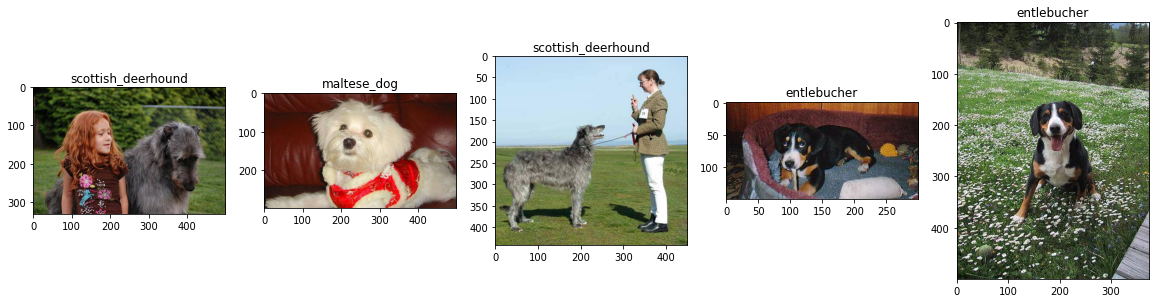

In [8]:
plot_imgs(dtf["img"].head(), dtf["label"].head())

### 1 - Data Analysis

###### Target

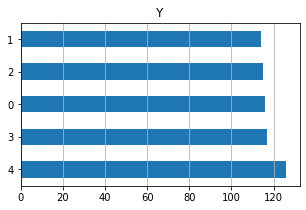

In [9]:
dtf["y"].value_counts().plot(kind="barh", title="Y", figsize=(5,3)).grid(axis='x')
plt.show()

In [10]:
n_classes = dtf["y"].nunique()
n_classes

5

###### Size

In [11]:
width = [img.shape[0] for img in dtf["img"]]
height = [img.shape[1] for img in dtf["img"]]

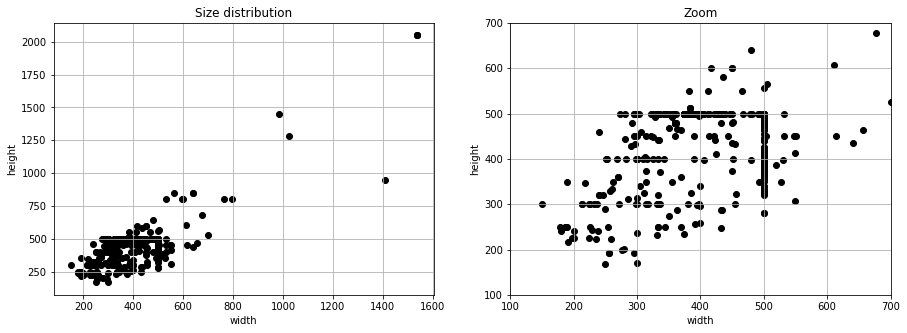

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

## all
ax[0].scatter(x=width, y=height, color="black")
ax[0].set(xlabel='width', ylabel="height", title="Size distribution")
ax[0].grid()

## zoom
ax[1].scatter(x=width, y=height, color="black")
ax[1].set(xlabel='width', ylabel="height", xlim=[100,700], ylim=[100,700], title="Zoom")
ax[1].grid()

plt.show()

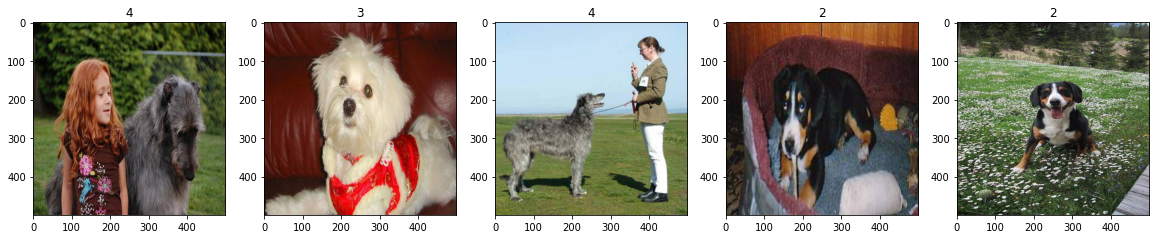

In [13]:
img_size = (500,500)

dtf["img"] = [cv2.resize(img, img_size) for img in dtf["img"]]
plot_imgs(dtf["img"].head(), dtf["y"].head())

###### Color

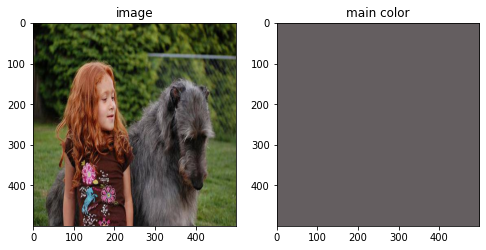

In [14]:
# try one
i = 0

rgb = dtf["img"][i].copy()
unique, counts = np.unique(rgb.reshape(-1,3), axis=0, return_counts=True)
rgb[:,:,0], rgb[:,:,1], rgb[:,:,2] = unique[np.argmax(counts)]
plot_imgs([dtf["img"][i], rgb], ["image","main color"])

In [15]:
# do all
r,g,b,y = [],[],[],[]
for img,label in tqdm(zip(dtf["img"],dtf["y"])):
    unique, counts = np.unique(img.reshape(-1,3), axis=0, return_counts=True)
    red, green, blue = unique[np.argmax(counts)]
    r.append(red)
    g.append(green)
    b.append(blue)
    y.append(label)

# Plot 3D
data = pd.DataFrame({"r":r,"g":g,"b":b,"y":y})
data["y"] = data["y"].astype(str)

fig = px.scatter_3d(data, x='r', y='g', z='b', color='y', title="RGB distribution", 
                    labels={"r":"red","g":"green","b":"blue"})
fig.show()

0it [00:00, ?it/s]

In [16]:
# keep the colors
img_shape = img_size+(3,)
img_shape

(500, 500, 3)

### 2 - Preprocessing

###### Scaling

In [17]:
dtf["img"] = dtf["img"]/255

###### Partitioning

In [18]:
split = 500

In [19]:
X_train = np.array([x for x in dtf["img"].head(split).values])
y_train = np.array([y for y in dtf["y"].head(split).values])
X_train.shape

(500, 500, 500, 3)

In [20]:
X_test = np.array([x for x in dtf["img"].tail(len(dtf)-split).values])
y_test = np.array([y for y in dtf["y"].tail(len(dtf)-split).values])
X_test.shape

(88, 500, 500, 3)

###### Data Augmentation

In [ ]:
data_augmentation = models.Sequential(name="data_augmentation", layers=[
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(factor=0.2),
    layers.RandomZoom(height_factor=0.2, width_factor=0.2)
])

plot_imgs([X_train[0], data_augmentation(X_train[0])], ["original","generated"])

In [ ]:
new_x, new_y = [], []
for x,y in tqdm(zip(X_train, y_train)):
    for n in range(5):
        new_x.append(data_augmentation(x))
        new_y.append(y)
X_augmented = X_train + new_x
y_augmented = y_train + new_y
print(len(X_augmented))

### 3 - Baseline (CNN)

###### Model Design

In [43]:
## Input
x_in = layers.Input(name="x_in", shape=img_shape)

## Conv + MaxPool
x_conv2d = layers.Conv2D(name="x_conv2d", filters=32, kernel_size=(3,3), activation="relu")(x_in)
x_maxpool = layers.MaxPooling2D(name='x_maxpool', pool_size=(2,2))(x_conv2d)

## Conv + MaxPool
x_conv2d2 = layers.Conv2D(name="x_conv2d2", filters=32, kernel_size=(3,3), activation="relu")(x_maxpool)
x_maxpool2 = layers.MaxPooling2D(name='x_maxpool2', pool_size=(2,2))(x_conv2d2)

## Flat + Dense
flat = layers.Flatten(name="flat")(x_maxpool2)
dense = layers.Dense(name="dense", units=128, activation='relu')(flat)

## Output
y_out = layers.Dense(name="y_out", units=n_classes, activation="softmax")(dense) #if binary -> 1 & sigmoid

## Compile
model = models.Model(inputs=x_in, outputs=y_out, name="CNN")
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"]) #if binary -> n & binary_crossentropy
model.summary()

Model: "CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
x_in (InputLayer)            [(None, 500, 500, 3)]     0         
_________________________________________________________________
x_conv2d (Conv2D)            (None, 498, 498, 32)      896       
_________________________________________________________________
x_maxpool (MaxPooling2D)     (None, 249, 249, 32)      0         
_________________________________________________________________
x_conv2d2 (Conv2D)           (None, 247, 247, 32)      9248      
_________________________________________________________________
x_maxpool2 (MaxPooling2D)    (None, 123, 123, 32)      0         
_________________________________________________________________
flat (Flatten)               (None, 484128)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               61968512

shape: (123, 123, 32)


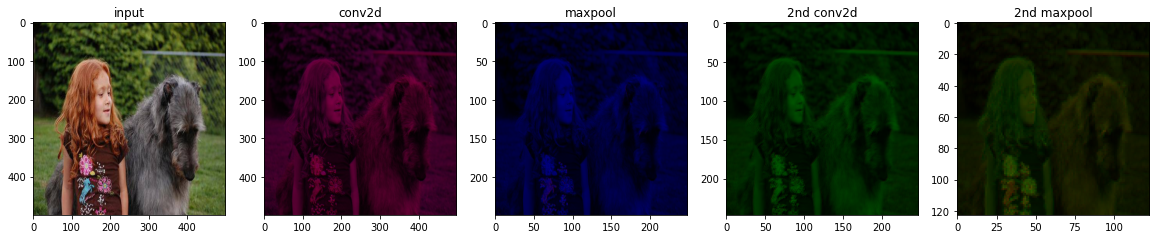

In [137]:
# check layers
x = X_train[0]
convx = model.layers[1](x)
maxpx = model.layers[2](convx)
convx2 = model.layers[3](maxpx)
maxpx2 = model.layers[4](convx2)

print("shape:", maxpx2.shape[1:])

plot_imgs([x[0], convx[0][:,:,24:27], maxpx[0][:,:,22:25], convx2[0][:,:,10:13], maxpx2[0][:,:,13:16]], 
          ["input","conv2d","maxpool","2nd conv2d","2nd maxpool"])

###### Train / Test

In [21]:
'''
Plot loss and metrics of keras training.
'''
def utils_plot_keras_training(training):
    metrics = [k for k in training.history.keys() if ("loss" not in k) and ("val" not in k)]
    fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(15,3))
    
    ## training
    ax[0].set(title="Training")
    ax11 = ax[0].twinx()
    ax[0].plot(training.history['loss'], "o-", color='black')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss', color='black')
    for metric in metrics:
        ax11.plot(training.history[metric], "o-", label=metric)
    ax11.set_ylabel("Score", color='steelblue')
    ax11.legend()
    
    ## validation
    ax[1].set(title="Validation")
    ax22 = ax[1].twinx()
    ax[1].plot(training.history['val_loss'], "o-", color='black')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Loss', color='black')
    for metric in metrics:
        ax22.plot(training.history['val_'+metric], "o-", label=metric)
    ax22.set_ylabel("Score", color="steelblue")
    plt.show()

Epoch 00012: early stopping


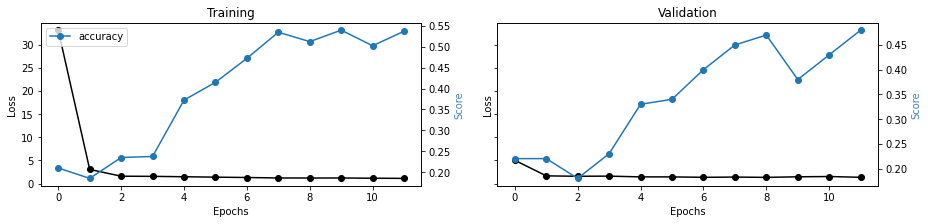

In [21]:
# Train
training = model.fit(x=X_train, y=y_train, 
                     epochs=100, batch_size=64, shuffle=True, verbose=0, validation_split=0.2,
                     callbacks=[callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)])
model = training.model
utils_plot_keras_training(training)

In [45]:
# Test
predicted_prob = model.predict(X_test)
predicted = [np.argmax(pred) for pred in predicted_prob]

###### Evaluate

In [22]:
'''
Evaluates a model performance.
:parameter
    :param y_test: array
    :param predicted: array
    :param predicted_prob: array
    :param figsize: tuple - plot setting
'''
def evaluate_multi_classif(y_test, predicted, predicted_prob, figsize=(15,5)):
    classes = np.unique(y_test)
    y_test_array = pd.get_dummies(y_test, drop_first=False).values
    
    ## Accuracy, Precision, Recall
    accuracy = metrics.accuracy_score(y_test, predicted)
    auc = metrics.roc_auc_score(y_test, predicted_prob, multi_class="ovr")
    print("Accuracy:",  round(accuracy,2))
    print("Auc:", round(auc,2))
    print("Detail:")
    print(metrics.classification_report(y_test, predicted))
    
    ## Plot confusion matrix
    cm = metrics.confusion_matrix(y_test, predicted)
    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, cbar=False)
    ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, yticklabels=classes, title="Confusion matrix")
    plt.yticks(rotation=0)

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=figsize)
    ## Plot roc
    for i in range(len(classes)):
        fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i], predicted_prob[:,i])
        ax[0].plot(fpr, tpr, lw=3, label='{0} (area={1:0.2f})'.format(classes[i], metrics.auc(fpr, tpr)))
    ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
    ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], xlabel='False Positive Rate', 
              ylabel="True Positive Rate (Recall)", title="Receiver operating characteristic")
    ax[0].legend(loc="lower right")
    ax[0].grid(True)
    
    ## Plot precision-recall curve
    for i in range(len(classes)):
        precision, recall, thresholds = metrics.precision_recall_curve(y_test_array[:,i], predicted_prob[:,i])
        ax[1].plot(recall, precision, lw=3, label='{0} (area={1:0.2f})'.format(
            classes[i], metrics.auc(recall, precision)))
    ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', ylabel="Precision", title="Precision-Recall curve")
    ax[1].legend(loc="best")
    ax[1].grid(True)
    plt.show()

Accuracy: 0.53
Auc: 0.82
Detail:
              precision    recall  f1-score   support

           0       0.64      0.47      0.54        15
           1       0.73      0.50      0.59        22
           2       0.45      0.81      0.58        16
           3       0.80      0.38      0.52        21
           4       0.35      0.57      0.43        14

    accuracy                           0.53        88
   macro avg       0.59      0.55      0.53        88
weighted avg       0.62      0.53      0.54        88



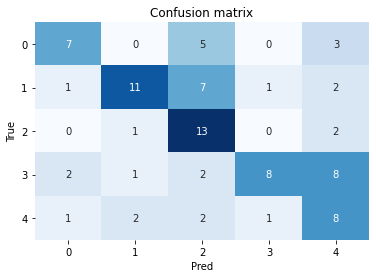

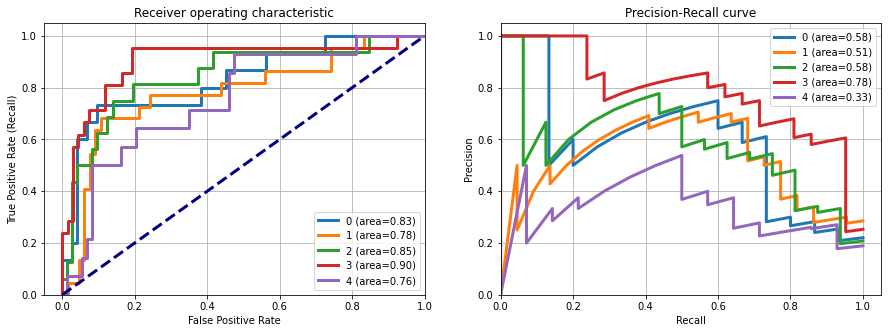

In [24]:
evaluate_multi_classif(y_test, predicted, predicted_prob, figsize=(15,5))

###### Explainability

In [23]:
'''
Use lime to build an a explainer.
:parameter
    :param model: pipeline with vectorizer and classifier
    :param img_instance: array - image
'''
def explainer_lime(model, img_instance):
    explainer = lime_image.LimeImageExplainer()
    explained = explainer.explain_instance(img_instance, model.predict, num_samples=1000)
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
    fig.suptitle("Image with highlighted features", fontsize=15)
    ax[0].imshow(img_instance)
    temp, mask = explained.get_image_and_mask(explained.top_labels[0], positive_only=False, hide_rest=False)
    ax[1].imshow(segmentation.mark_boundaries(temp/2+0.5, mask))
    plt.show()

True: 3 --> Pred: 3 | Prob: 0.75


100% |########################################################################|


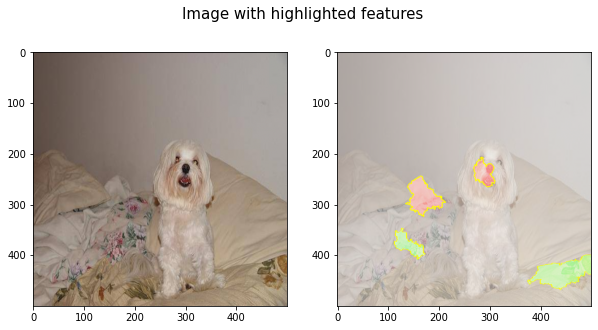

In [52]:
i = 10
print("True:", y_test[i], "--> Pred:", predicted[i], "| Prob:", round(np.max(predicted_prob[i]),2))
explainer_lime(model, img_instance=X_test[i])

### 4 - Model Desing & Testing (Transfer Learning)

###### Model Design

In [24]:
# Load pre-trained
from tensorflow.keras.applications import vgg16

base = vgg16.VGG16(weights="imagenet", include_top=False, input_shape=img_shape)
base.trainable = False
base.summary()

58900480/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 500, 500, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 500, 500, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 500, 500, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 250, 250, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 250, 250, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 250, 250, 128)     147584    
______________________________________________________________

In [25]:
# Add new head
model = models.Sequential(name="TransferLearning", layers=[
    base,
    layers.Flatten(name="flat"),
    layers.Dense(name="dense", units=128, activation='relu'),
    layers.Dense(name="y_out", units=n_classes, activation="softmax")
])

model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

Model: "TransferLearning"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 15, 15, 512)       14714688  
_________________________________________________________________
flat (Flatten)               (None, 115200)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               14745728  
_________________________________________________________________
y_out (Dense)                (None, 5)                 645       
Total params: 29,461,061
Trainable params: 14,746,373
Non-trainable params: 14,714,688
_________________________________________________________________


###### Train / Test

Epoch 1/10
13/13 [==============================] - 297s 23s/step - loss: 10.1819 - accuracy: 0.2550 - val_loss: 5.5457 - val_accuracy: 0.1700
Epoch 2/10
13/13 [==============================] - 306s 24s/step - loss: 1.5874 - accuracy: 0.5775 - val_loss: 1.6071 - val_accuracy: 0.5400
Epoch 3/10
13/13 [==============================] - 316s 25s/step - loss: 0.5263 - accuracy: 0.8225 - val_loss: 1.1038 - val_accuracy: 0.6600
Epoch 4/10
13/13 [==============================] - 318s 25s/step - loss: 0.1047 - accuracy: 0.9725 - val_loss: 1.1436 - val_accuracy: 0.6800
Epoch 5/10
13/13 [==============================] - 319s 25s/step - loss: 0.0627 - accuracy: 0.9925 - val_loss: 0.8073 - val_accuracy: 0.7300
Epoch 6/10
13/13 [==============================] - 315s 25s/step - loss: 0.0270 - accuracy: 1.0000 - val_loss: 0.7473 - val_accuracy: 0.7600
Epoch 7/10
13/13 [==============================] - 320s 25s/step - loss: 0.0178 - accuracy: 0.9975 - val_loss: 0.7771 - val_accuracy: 0.7300
Epoch

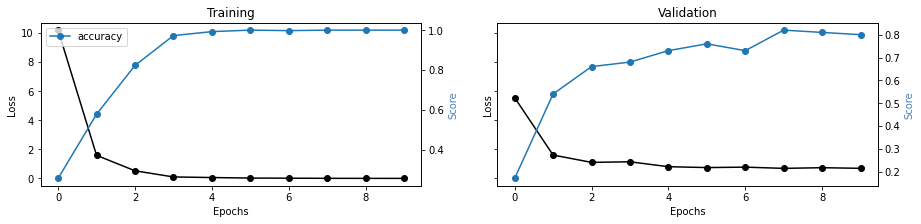

In [26]:
# Train
training = model.fit(x=X_train, y=y_train, 
                     epochs=10, batch_size=32, shuffle=True, verbose=1, validation_split=0.2,
                     callbacks=[callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)])
model = training.model
utils_plot_keras_training(training)

In [27]:
# Test
predicted_prob = model.predict(X_test)
predicted = [np.argmax(pred) for pred in predicted_prob]

###### Evaluate

Accuracy: 0.7
Auc: 0.93
Detail:
              precision    recall  f1-score   support

           0       0.83      0.67      0.74        15
           1       0.67      0.36      0.47        22
           2       0.68      0.81      0.74        16
           3       0.62      0.95      0.75        21
           4       0.85      0.79      0.81        14

    accuracy                           0.70        88
   macro avg       0.73      0.72      0.70        88
weighted avg       0.72      0.70      0.69        88



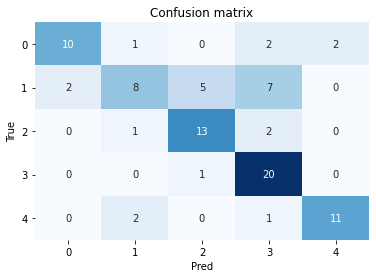

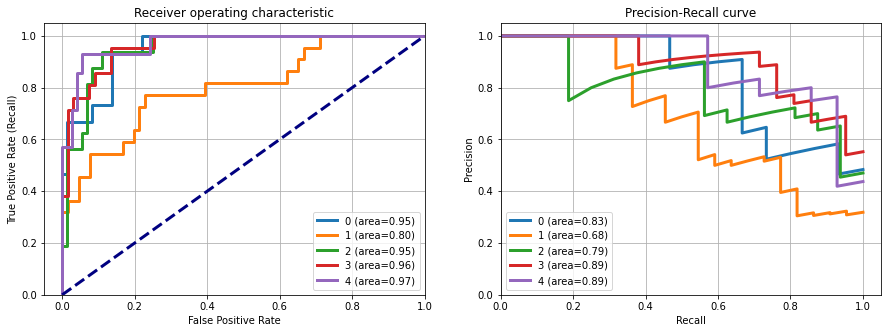

In [28]:
evaluate_multi_classif(y_test, predicted, predicted_prob, figsize=(15,5))

###### Explainability

True: 3 --> Pred: 3 | Prob: 0.95


100% |########################################################################|


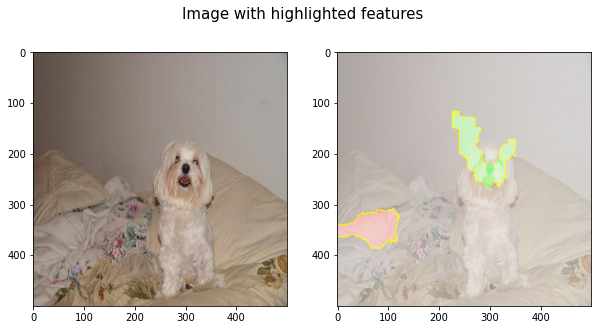

In [42]:
i = 10
print("True:", y_test[i], "--> Pred:", predicted[i], "| Prob:", round(np.max(predicted_prob[i]),2))
explainer_lime(model, img_instance=X_test[i])

### 5 - Model Desing & Testing (Transformers)

###### Load model

In [40]:
model_name = "google/vit-base-patch16-224"

prep = transformers.AutoFeatureExtractor.from_pretrained(model_name)
vit = transformers.TFAutoModel.from_pretrained(model_name)

ValueError: Unrecognized configuration class <class 'transformers.models.vit.configuration_vit.ViTConfig'> for this kind of AutoModel: TFAutoModel.
Model type should be one of RemBertConfig, RoFormerConfig, Wav2Vec2Config, ConvBertConfig, LEDConfig, BlenderbotSmallConfig, MT5Config, T5Config, MobileBertConfig, DistilBertConfig, AlbertConfig, CamembertConfig, XLMRobertaConfig, PegasusConfig, MarianConfig, MBartConfig, MPNetConfig, BartConfig, BlenderbotConfig, LongformerConfig, RobertaConfig, DebertaV2Config, DebertaConfig, FlaubertConfig, HubertConfig, BertConfig, OpenAIGPTConfig, GPT2Config, TransfoXLConfig, XLNetConfig, XLMConfig, CTRLConfig, ElectraConfig, FunnelConfig, LxmertConfig, DPRConfig, LayoutLMConfig.

###### Model Design

In [63]:
# Preprocess 
X_train = [cv2.resize(img, (prep.size,prep.size)) for img in X_train]
X_train = [prep(x) for x in X_train]

X_test = [cv2.resize(img, (prep.size,prep.size)) for img in X_test]
X_test = [prep(x) for x in X_test]

shape = X_train[0]["pixel_values"][0].shape
print(shape)

error: OpenCV(4.5.5) :-1: error: (-5:Bad argument) in function 'resize'
> Overload resolution failed:
>  - src is not a numpy array, neither a scalar
>  - Expected Ptr<cv::UMat> for argument 'src'


In [77]:
x_in = layers.Input(name="x_in", shape=shape, dtype='float32')
vit_out = vit(x_in)[0][:,0,:]
y_out = layers.Dense(name="y_out", units=n_classes, activation="softmax")(vit_out)

model = models.Model(inputs=x_in, outputs=y_out, name="ViT")
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

Model: "ViT"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
x_in (InputLayer)            [(None, 3, 224, 224)]     0         
_________________________________________________________________
tf_vi_t_model_2 (TFViTModel) TFBaseModelOutputWithPool 86389248  
_________________________________________________________________
tf_op_layer_strided_slice_6  [(None, 768)]             0         
_________________________________________________________________
y_out (Dense)                (None, 5)                 3845      
Total params: 86,393,093
Trainable params: 86,393,093
Non-trainable params: 0
_________________________________________________________________


###### Train / Test

In [71]:
# Train
training = model.fit(x=X_train, y=y_train, 
                     epochs=10, batch_size=64, shuffle=True, verbose=1, validation_split=0.2,
                     callbacks=[callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)])
model = training.model
utils_plot_keras_training(training)

TypeError: Tensor is unhashable. Instead, use tensor.ref() as the key.

In [ ]:
# Test
predicted_prob = model.predict(np.array(X_test))
predicted = [np.argmax(pred) for pred in predicted_prob]

###### Evaluate

In [ ]:
evaluate_multi_classif(y_test, predicted, predicted_prob, figsize=(15,5))

###### Explainability

In [ ]:
i = 2
print("True:", y_test[i], "--> Pred:", predicted[i], "| Prob:", round(np.max(predicted_prob[i]),2))
explainer_lime(model, img_instance=X_test[i])